In [ ]:
'''
Contiene el consolidado de los casos positivos de Coronavirus COVID-19 en Colombia reportados por el Instituto Nacional de Salud (INS). Incluye variables como género, departamento, grupo etáreo, entre otras.

https://www.ins.gov.co/Noticias/Paginas/Coronavirus.aspx

https://www.datos.gov.co/Salud-y-Protecci-n-Social/Casos-positivos-de-COVID-19-en-Colombia/gt2j-8ykr/data

Fecha de notificación	| Fecha de notificación a SIVIGILA
Codigo DIVIPOLA	        | Por seguridad de las personas, algunos datos serán limitados evitando así la      
                          exposición y posible identificación en determinados municipios.
Ciudad de ubicación	    | Por seguridad de las personas, algunos datos serán limitados evitando así la 
                          exposición y posible identificación en determinados municipios.
Departamento o Distrito	| Por seguridad de las personas, algunos datos serán limitados evitando así la 
                          exposición y posible identificación en determinados municipios.
atención	            | * Corresponde a muertes no relacionadas con COVID-19, aún si eran casos activos 
                          **Hay pacientes recuperados para COVID-19, que pueden permanecer en hospitalización 
                          por otras comorbilidades
Tipo	                | Por seguridad de las personas, algunos datos serán limitados evitando así la 
                          exposición y posible identificación en determinados municipios.
FIS                     | Fecha de confirmación por laboratorio
'''

In [25]:
import pandas as pd
import numpy as np
url = 'https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?'
url = url + 'accessType=DOWNLOAD&bom=true&format=true&delimiter=%3B'
#url = 'https://www.ins.gov.co/BoletinesCasosCOVID19Colombia/'
#file = '2020-05-30.xlsx',
#data = pd.read_excel(url + file)
data = pd.read_csv(url, sep=';')

#Replace \n (newline) for all columns
data.rename(columns=lambda s: s.replace(' ', '_'), inplace=True)

#Información de latitud y longitud para los departamentos del dataset(únicamente)
data_geo = pd.read_csv('dataset/departamentos_geocode_lat_lon.csv')

#Feature Engineering
#Fechas
data['FIS'] = pd.to_datetime(data['FIS'], format='%Y-%m-%d', errors='coerce', yearfirst=True, exact=False)

data['Fecha_de_muerte'] = pd.to_datetime(data['Fecha_de_muerte'], format='%Y-%m-%d', errors='coerce',   
yearfirst=True, exact=False)

data['Fecha_diagnostico'] = pd.to_datetime(data['Fecha_diagnostico'], format='%Y-%m-%d', errors='coerce', 
yearfirst=True, exact=False)

data['Fecha_recuperado'] = pd.to_datetime(data['Fecha_recuperado'], format='%Y-%m-%d', errors='coerce', 
yearfirst=True, exact=False)

data['fecha_reporte_web'] = pd.to_datetime(data['fecha_reporte_web'], format='%Y-%m-%d', errors='coerce', 
yearfirst=True, exact=False)

#Estado
data['Estado'] = np.where(data['Estado'] == 'leve', 'Leve', data['Estado'])
data['Estado'] = data['Estado'].str.strip()
data['Departamento_o_Distrito_'] = data['Departamento_o_Distrito_'].str.strip()
data['Ciudad_de_ubicación'] = data['Ciudad_de_ubicación'].str.strip()
data['País_de_procedencia'] = data['País_de_procedencia'].str.strip()
data['Sexo'] = data['Sexo'].str.strip()
data['atención'] = data['atención'].str.strip()
data['Tipo'] = data['Tipo'].str.strip()
data['Sexo'] = data['Sexo'].str.upper()

#Feature Engenieering
#New Features
data['Recuperado'] = np.where(data['Fecha_recuperado'].notnull(), 'Si', 'No')
data['Falleció'] = np.where(data['Fecha_de_muerte'].notnull(), 'Si', 'No')
data['Extranjero'] = np.where(data['País_de_procedencia'] == 'Colombia', 'No', 'Si')

#Edad
data['Rango_Edad'] = pd.cut(x=data['Edad'], bins=[0, 5, 15, 25, 45, 65, 75, 999],
                    labels=['0-5', '5-15', '15-25', '25-45', '45-65', '65-75', '75->'])

#Días Recuperación
data['Días de tratamiento'] = abs(data['Fecha_recuperado'] - data['FIS'])
data['Días de tratamiento'] = data['Días de tratamiento'].astype('timedelta64[D]')
data['Días de tratamiento'].fillna(0, inplace=True)
data['Días de tratamiento'] = data['Días de tratamiento'].astype(int)

#Latitud y Longitud (para Departamento)
data = data.join(data_geo.set_index('Departamento'), on='Departamento_o_Distrito_')

#Display datafile info
print('Registros: {:,}'.format(data.shape[0]))

Registros: 30,493


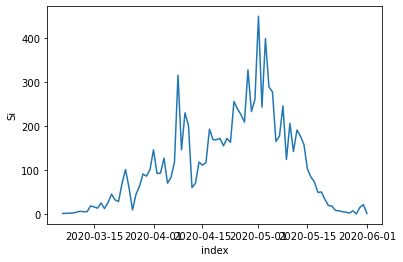

In [83]:
import seaborn as sns
sns.lineplot(x=df.index, y="Si", data=df)

In [3]:
data.columns

Index(['ID_de_caso', 'Fecha_de_notificación', 'Codigo_DIVIPOLA',
       'Ciudad_de_ubicación', 'Departamento_o_Distrito_', 'atención', 'Edad',
       'Sexo', 'Tipo', 'Estado', 'País_de_procedencia', 'FIS',
       'Fecha_de_muerte', 'Fecha_diagnostico', 'Fecha_recuperado',
       'fecha_reporte_web', 'Tipo_recuperación', 'Recuperado', 'Fallecio',
       'Extranjero', 'Ocupa_UCI', 'Rango_Edad', 'Dias_Recuperacion',
       'Dias_Sobrevivencia', 'Unnamed: 0', 'dpto_geocode', 'dpto_coords',
       'lat', 'lon'],
      dtype='object')

In [165]:
import plotly.express as px
dg = data.groupby(['fecha_reporte_web', 'Sexo'])['fecha_reporte_web'].agg(['count']).reset_index()
dg.rename(columns={'count':'Número de casos'}, inplace=True)
fig = px.line(dg, x=dg.fecha_reporte_web, y='Número de casos', labels={'x':'Fecha'}, color='Sexo')
fig.show()

In [154]:
import plotly.express as px
dg = data.groupby('fecha_reporte_web')['fecha_reporte_web'].agg(['count'])
dg.rename(columns={'count':'Número de casos'}, inplace=True)
fig = px.line(dg, x=dg.index, y='Número de casos', labels={'x':'Fecha'})
fig.show()

In [176]:
import plotly.graph_objects as go

fig = go.Figure()

# Add traces
#Total Casos
dg = data.groupby('fecha_reporte_web')['fecha_reporte_web'].agg(['count'])
dg.rename(columns={'count':'Número de casos'}, inplace=True)
fig.add_trace(go.Scatter(x=dg.index, y=dg['Número de casos'],
                    mode='lines+markers',
                    name='Total Casos'))
#Total Casos : Mujeres
dg = data[data['Sexo'] == 'F'].groupby('fecha_reporte_web')['fecha_reporte_web'].agg(['count'])
dg.rename(columns={'count':'Número de casos'}, inplace=True)
fig.add_trace(go.Scatter(x=dg.index, y=dg['Número de casos'],
                    mode='lines',
                    name='Mujeres'))

#Total Casos : Hombres
dg = data[data['Sexo'] == 'M'].groupby('fecha_reporte_web')['fecha_reporte_web'].agg(['count'])
dg.rename(columns={'count':'Número de casos'}, inplace=True)
fig.add_trace(go.Scatter(x=dg.index, y=dg['Número de casos'],
                    mode='lines',
                    name='Hombres'))

fig.show()

In [15]:
#Missing Null Values
data['atención'].fillna(data['atención'].mode()[0], inplace=True)
data['Estado'].fillna(data['Estado'].mode()[0], inplace=True)
data['Tipo'].fillna(data['Tipo'].mode()[0], inplace=True)

In [14]:
data['atención'].value_counts()

Casa            18131
Recuperado       9661
Hospital         1443
Fallecido         969
Hospital UCI      289
Name: atención, dtype: int64

In [27]:
import plotly.express as px
fig = px.scatter(data[(data['Edad'] > 0)&(data['Días de tratamiento'] > 0)], x="Edad", y="Días de tratamiento", color='Falleció')
fig.show()